In [134]:
import numpy as np
from tsaugmentation.transformations.compute_similarities import ComputeSimilarities
from tsaugmentation.transformations.similarity_model import SimilarityModel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set()
plt.rcParams.update({'font.size': 22})

In [18]:
versions = 6
transformations = ['jitter', 'scaling', 'magnitude_warp', 'time_warp']

In [19]:
orig = np.load('../data_tourism/transformed_datasets/tourism_original.npy')
transf = []
for t in transformations:
    transf_ = []
    for v in range(1, versions+1):
        transf_.append(np.load(f'../data_tourism/transformed_datasets/tourism_version_{v}_10samples_single_transf_{t}.npy'))
    transf.append(transf_)

In [20]:
transf = np.array(transf)

In [21]:
# Compute distance between original version and transformed version
avg_sim_base_transf = []
for t in range(len(transformations)):
    avg_transf = []
    for v in range(versions):
        avg_sample = []
        for s in range(transf[t][v].shape[0]):
            avg_sample.append(ComputeSimilarities(dataset=orig, transf_dataset=transf[t][v][s]) \
                .compute_mean_similarity_elementwise())
        avg_transf.append(avg_sample)
    avg_sim_base_transf.append(avg_transf)

In [22]:
df_ = np.array(avg_sim_base_transf)

In [23]:
transformation = np.array(transformations)
version = np.array(np.arange(versions))
sample = np.array(np.arange(10))
cols = pd.MultiIndex.from_product([transformation, version, sample])
df = pd.DataFrame(df_.reshape(1, -1), columns=cols).melt(var_name=['transformation', 'version', 'sample'])

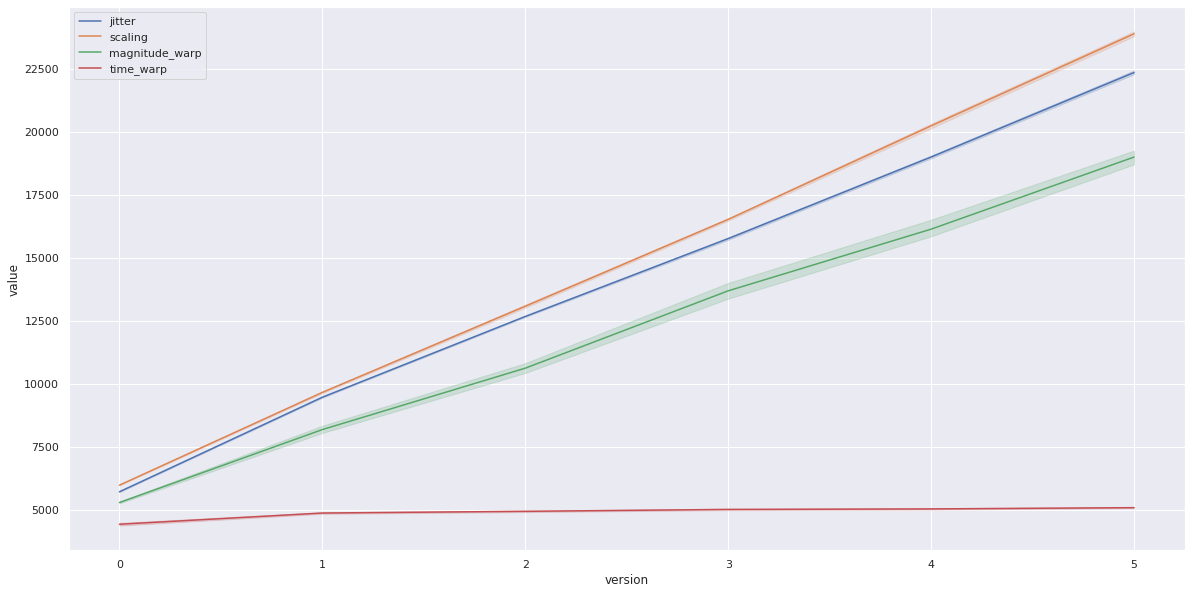

In [24]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))

fg = sns.lineplot(x='version', 
                  y='value',
                  hue='transformation',
                  data=df, 
                  ax=ax)    
plt.legend()
plt.show()

In [25]:
# Compute distance intra each version and compare distributions between versions

# Compute distance between series in the original dataset
orig_dist = []
for i in range(orig.shape[1]):
    orig_dist.append(ComputeSimilarities(dataset=orig, transf_series=orig[:,i]) \
                    .compute_similarity_single_series_and_dataset())

In [31]:
dist_base_transf = []
for t in range(len(transformations)):
    transf_dist = []
    print(f'transf {t}')
    for v in range(versions):
        sample_dist = []
        print(f'version {v}')
        for s in range(transf[t][v].shape[0]):
            series_dist = []
            print(f'series {s}')
            for i in range(transf[t][v][s].shape[1]):
                series_dist.append(ComputeSimilarities(dataset=transf[t][v][s], 
                                                       transf_series=transf[t][v][s][:,i]) \
                                    .compute_similarity_single_series_and_dataset())
            sample_dist.append(series_dist)
        transf_dist.append(sample_dist)
    dist_base_transf.append(transf_dist)

In [32]:
dist_base_transf = np.array(dist_base_transf)

In [41]:
t, v, s, ts = dist_base_transf.shape

In [55]:
transformations = ['jitter', 'scaling', 'magnitude_warp', 'time_warp']

In [119]:
df = pd.DataFrame({'transformation': np.repeat(transformations,v*s*ts),
                 'version': np.tile(np.repeat(np.arange(v, dtype=np.int32), s*ts), t), 
                 'sample': np.tile(np.repeat(np.arange(s, dtype=np.int32), ts), t*v),
                 'series': np.tile(np.arange(ts, dtype=np.int32), t*v*s),
                 'dist': np.squeeze(dist_base_transf.reshape(t*v*s*ts,-1).astype('float64'))})

In [139]:
# Assert that the creation of the dataframe is correct
# Average distance series 2 of version 4 of scaling transformation to all the other series on the version 4 dataset

assert math.isclose(dist_base_transf[1, 3, 0, 1], 
                    df[(df['transformation']=='scaling')&(df['version']==3)&(df['sample']==0)&(df['series']==1)].values[:,4][0])

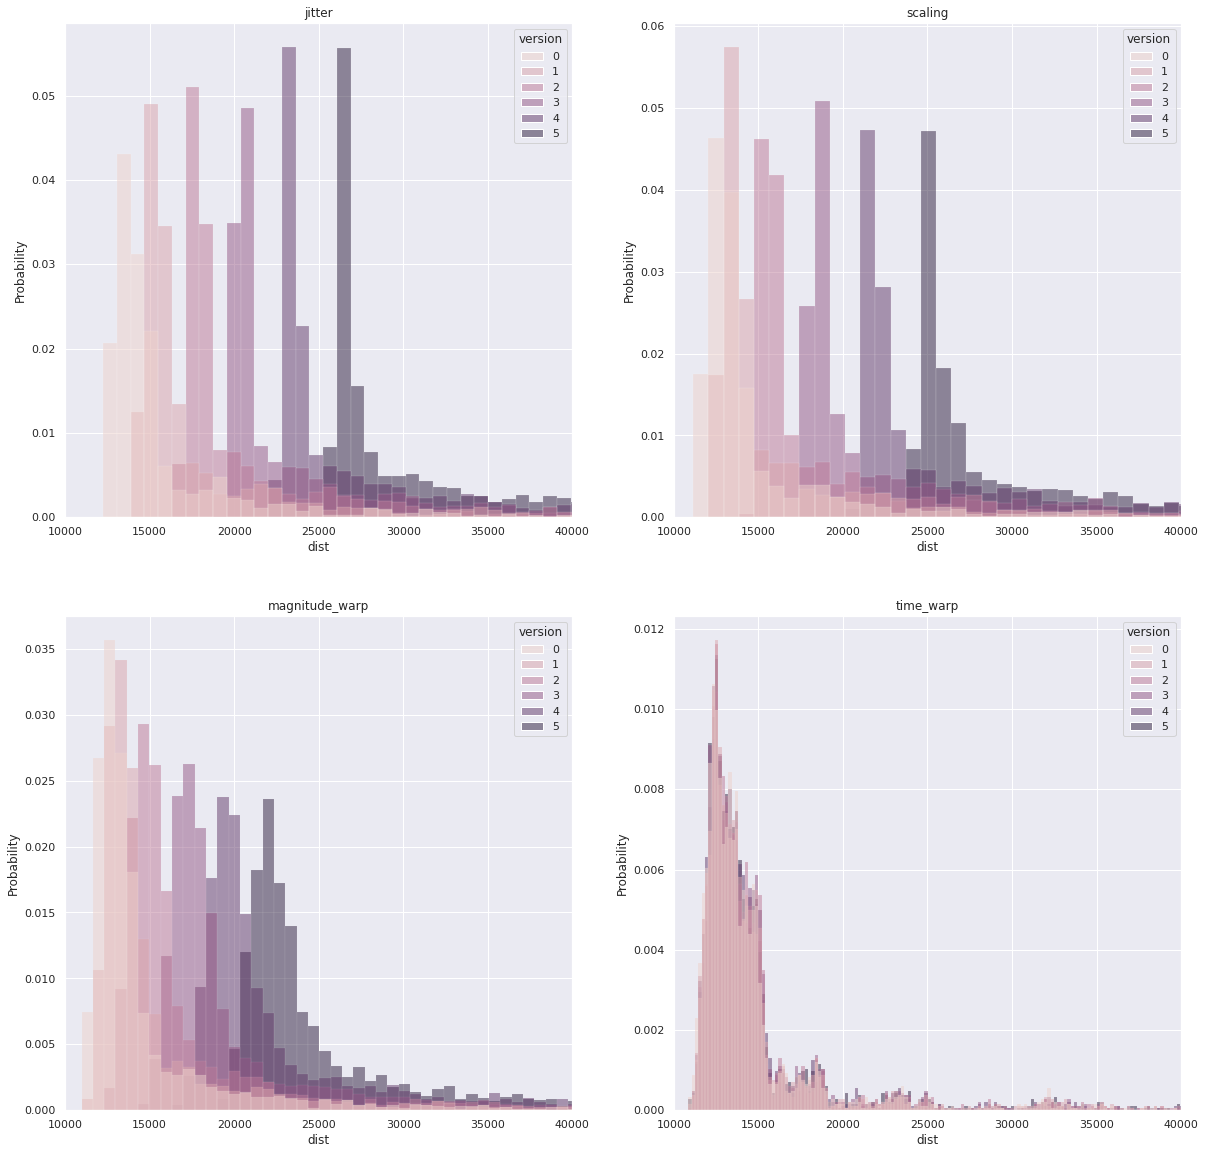

In [154]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()
for t in range(len(transformations)):
    sns.histplot(df[df.transformation==transformations[t]], 
                x="dist", 
                hue="version", 
                stat="probability",
                ax=ax[t])
    ax[t].set_xlim(10000, 40000)
    ax[t].set_title(transformations[t])
plt.show();